# 0.0 - Imports 

In [1]:
import pandas    as pd
import numpy     as np
import seaborn   as sns
import itertools as it

from IPython.core.display import HTML
from IPython.display      import Image

from matplotlib import pyplot as plt

## 0.1 - Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()



In [3]:
def contains(df_a,df_b,cols_a,cols_b):
    
    '''
    Verifica se as features cols_a do dataset A 
    corresponde parcial ou totalmente às features 
    cols_b do dataset B.
    '''
    
    dic = {x:[] for x in ['esta','em','quanto','% Falso','% Verdadeiro']}
    
    for col_a,col_b in it.product(cols_a,cols_b):
        
        if np.in1d(df_a[col_a].unique(),df_b[col_b].unique()).all():
            result = 'totalmente'
            percent = 0.0
        elif np.in1d(df_a[col_a].unique(),df_b[col_b].unique()).any():
            result = 'parcialmente'
            a = np.in1d(df_a[col_a].unique(),df_b[col_b].unique())
            percent= (len(a) - np.count_nonzero(a)) / float(len(a))
        else:
            result = 'não está'
            percent = 1.0
        
        dic['esta'].append(col_a)
        dic['em'].append(col_b)
        dic['quanto'].append(result)
        dic['% Falso'].append(percent)
        dic['% Verdadeiro'].append(1-percent)
        
    return pd.DataFrame(dic)

def NA_calc(df):
    na = df.isna().sum()
    return pd.DataFrame({'NA(#)': na, 'NA(%)':na/df.shape[0]})

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 - Paths

In [5]:
rawpath = '../data/raw/'
modelspath  = '../models'
imgpath = '../reports/figures/'

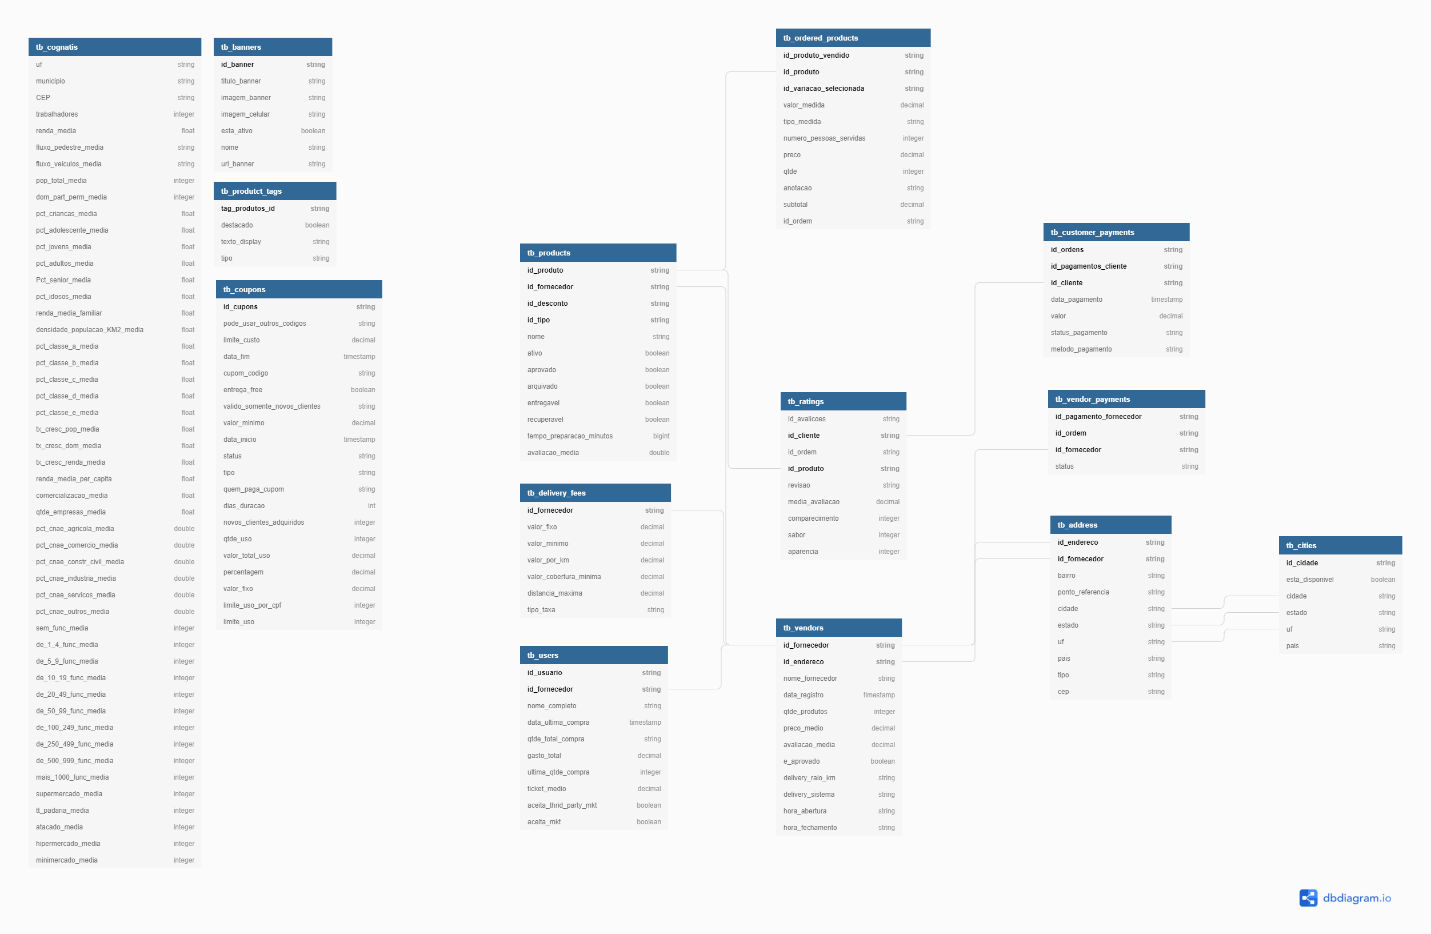

In [6]:
Image(imgpath+'MER.png')

## 0.3 Load datasets

In [7]:
products = pd.read_csv(rawpath+'tb_products.csv', delimiter=';')
ordered_products = pd.read_csv(rawpath+'tb_ordered_products.csv', delimiter=';')
products_tag = pd.read_csv(rawpath+'tb_product_tags.csv', delimiter=';')
ratings = pd.read_csv(rawpath+'tb_ratings.csv',delimiter = ';')
coupons = pd.read_csv(rawpath+'tb_coupons.csv',delimiter = ';')
vendors = pd.read_csv(rawpath+'tb_vendors.csv',delimiter = ';')
payment = pd.read_csv(rawpath+'tb_customer_payments.csv',delimiter = ';')
users   = pd.read_csv(rawpath+'tb_users.csv',delimiter = ';')
cities  = pd.read_csv(rawpath+'tb_cities.csv',delimiter = ';')
address  = pd.read_csv(rawpath+'tb_addresses.csv',delimiter = ';')

# 1 - relations  info in dataset 

**O que fazer:**

    - Procurar mais relações entre vendors, products e ordered products
    - entender as ordem de pagamentos, id_ordem e outros relacionados ao pagamento aos fornecedores.
    - tentar montar uma tabela a partir de vendors que permita analisar o faturamento total de cada loja (OBJETIVO FINAL)
    _________________________________________

DESCOBERTAS que podem ser úteis:

- A tabela ratings só tem votação de 225 produtos.
- A tabela ratings apresenta produtos que não estão na tabela de produtos;
- ids de cupons não estão relacionados com id_disconto na tabela de produtos;
- Todos os fornecedores constam nas tabelas de produto;
- Existem tags de produtos que não estão na tabela de produtos;
- Existem  143 vendedores sem produtos à venda;
- Os valores médios de produtos de todos os fornecedores é 0;
- Todos os clientes estão na tabela de usuários.
- Fornecedores não constam na tabela de usuários.
- Não há produtos entre os produtos vendidos.
- ~46% dos produtos não estão na tabela ordered_products;
- ~38% da id_ordem de ordered_products estão nas tabelas de pagamento;
- ~20% das tags de produto existem em id_tipo de products;
- Todos os endereços de vendedores correspondem à tabela tb_adresses;
- 94% das ordens de tb_payments existem na tabela de pedidos ordenados;

- Os vendedores se espalham em 57 cidades e 14 estados;

## 1.1 - Products Description

In [8]:
NA_calc(products)

,NA(#),NA(%)
id_produto,0,0.000000
id_fornecedor,0,0.000000
id_disconto,2888,0.909034
id_tipo,1,0.000315
nome,0,0.000000
ativo,7,0.002203
aprovado,0,0.000000
arquivado,1,0.000315
entregavel,0,0.000000
recuperavel,0,0.000000


## 1.2 - Rating relations

In [9]:
len(ratings['id_produto'].unique()),len(ratings['id_produto'])

(225, 47224)

In [10]:
contains(ratings,products,['id_produto'],['id_produto'])

,esta,em,quanto,% Falso,% Verdadeiro
0,id_produto,id_produto,parcialmente,0.017778,0.982222


In [11]:
np.in1d(ratings['id_produto'].unique(),products['id_produto'].unique()).any()

True

In [12]:
existing_products = ratings['id_produto'].unique()[np.in1d(ratings['id_produto'].unique(),products['id_produto'].unique())]

## 1.3 - Coupons relations 

In [13]:
np.in1d(coupons['id_cupons'],products['id_disconto']).any()

False

## 1.4 - products tags relations

In [14]:
np.in1d(products_tag['tag_produtos_id'],products['id_tipo']).any()
contains(products_tag,products,['tag_produtos_id'],['id_tipo'])

,esta,em,quanto,% Falso,% Verdadeiro
0,tag_produtos_id,id_tipo,parcialmente,0.798165,0.201835


## 1.5 Vendors relations

In [15]:
test = products[['id_fornecedor','id_produto']].groupby('id_fornecedor')['id_produto'].count()
test.shape

(260,)

In [16]:
vendors_no_products = np.in1d(vendors['id_fornecedor'],products['id_fornecedor'])

len(vendors_no_products) - np.count_nonzero(vendors_no_products)

143

In [17]:
contains(vendors,address,['id_endereco'],['id_endereco'])

,esta,em,quanto,% Falso,% Verdadeiro
0,id_endereco,id_endereco,totalmente,0.0,1.0


In [37]:
test = address.loc[np.in1d(address['id_endereco'],vendors['id_endereco']),:]
len(test['cidade'].unique())

57

In [39]:
contains(vendors,users,['id_fornecedor'],['id_fornecedor'])

,esta,em,quanto,% Falso,% Verdadeiro
0,id_fornecedor,id_fornecedor,totalmente,0.0,1.0


In [40]:
vendors.shape[0]/len(vendors['id_fornecedor'].unique())

1.0

## 1.6 - Payments relations

In [18]:
NA_calc(ordered_products)

,NA(#),NA(%)
id_produto_vendido,0,0.000000
id_produto,106,0.006663
id_variacao_selecionada,146,0.009178
valor_medida,104,0.006538
tipo_medida,104,0.006538
numero_pessoas_servidas,106,0.006663
preco,148,0.009303
qtde,148,0.009303
anotacao,15081,0.948014
subtotal,192,0.012069


In [19]:
NA_calc(payment)

,NA(#),NA(%)
id_ordens,0,0.0
id_pagamentos_cliente,0,0.0
id_cliente,0,0.0
data_pagamento,0,0.0
valor,0,0.0
status_pagamento,0,0.0
metodo_pagamento,0,0.0


In [20]:
contains(payment,users,['id_cliente'],['id_usuario'])

,esta,em,quanto,% Falso,% Verdadeiro
0,id_cliente,id_usuario,totalmente,0.0,1.0


In [21]:
contains(payment,ordered_products,['id_ordens'],['id_ordem'])

,esta,em,quanto,% Falso,% Verdadeiro
0,id_ordens,id_ordem,parcialmente,0.050105,0.949895


## 1.7 - Users relations

In [22]:
NA_calc(users)

,NA(#),NA(%)
id_usuario,0,0.000000
id_fornecedor,6620,0.942617
nome_completo,402,0.057240
data_ultima_compra,4274,0.608572
qtde_total_compra,18,0.002563
gasto_total,18,0.002563
ultima_qtde_compra,18,0.002563
ticket_medio,18,0.002563
aceita_thrid_party_mkt,16,0.002278
aceita_mkt,16,0.002278
